In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import requests

In [3]:
df_id = pd.read_csv('/content/drive/MyDrive/Cherry Blossom/DATA/washingtondc.csv')

In [4]:
# df_list = []

In [5]:
import requests
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# API Request
base_url = "https://www.ncei.noaa.gov/access/services/data/v1"
params = {
    "dataset": "daily-summaries",
    "stations": "USW00013743",
    "datatypeid": ["TMAX", "TMIN", "TAVG", "PRCP", "RHUM", "SUNH", "SNOW"],
    "startDate": "2000-01-01",
    "endDate": "2025-02-21",
    "format": "json"
}


response = requests.get(base_url, params=params)

if response.status_code == 200:
    data = response.json()
    df = pd.DataFrame(data)

df

,FMTM,WSF2,STATION,WSF5,SNOW,PRCP,WT08,SNWD,DATE,WDF2,...,WT21,WT19,RHMX,ASLP,RHAV,ASTP,RHMN,AWBT,ADPT,WT07
0,1812,67,USW00013743,72,0,0,1,0,2000-01-01,160,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1453,112,USW00013743,130,0,0,1,0,2000-01-02,200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2345,94,USW00013743,103,0,0,NaN,0,2000-01-03,170,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1113,148,USW00013743,183,0,310,NaN,0,2000-01-04,190,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0808,125,USW00013743,152,0,0,NaN,0,2000-01-05,310,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9179,NaN,157,USW00013743,268,0,0,NaN,0,2025-02-17,300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9180,NaN,98,USW00013743,139,0,0,NaN,0,2025-02-18,340,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9181,NaN,94,USW00013743,112,3,0,NaN,0,2025-02-19,340,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9182,NaN,116,USW00013743,215,0,0,NaN,0,2025-02-20,310,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Check available columns
print("Columns before processing:", df.columns)

# Ensure 'DATE' column is in datetime format
df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")

# Sort by date
df = df.sort_values(by='DATE', ascending=False).reset_index(drop=True)

# Drop unnecessary columns if they exist
cols_to_drop = ['TAVG', 'STATION', 'SNWD']
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns], errors='ignore')

# Fill missing precipitation values
if 'PRCP' in df.columns:
    df['PRCP'].fillna(0, inplace=True)

# Convert temperature values from tenths of a degree to degrees
for col in ['TMAX', 'TMIN', 'TAVG']:
    if col in df.columns:
        df[col] = df[col].apply(lambda x: int(x) / 10 if pd.notna(x) else x)

# Function to fill missing temperature values
def fill_missing_tmax(df, column="TMAX", window=7):
    df_filled = df.copy()
    if column not in df_filled.columns:
        return df_filled  # Skip if column does not exist

    nan_indices = df_filled[df_filled[column].isna()].index

    for idx in nan_indices:
        start = max(idx - window, 0)
        end = min(idx + window + 1, len(df_filled))
        window_values = df_filled[column].iloc[start:end].dropna().values
        if len(window_values) > 0:
            df_filled.at[idx, column] = np.mean(window_values)

    return df_filled

# Apply missing value filling
df = fill_missing_tmax(df, column="TMAX", window=7)
df = fill_missing_tmax(df, column="TMIN", window=7)

# Final DataFrame check
print("Columns after processing:", df.columns)

Columns before processing: Index(['FMTM', 'WSF2', 'STATION', 'WSF5', 'SNOW', 'PRCP', 'WT08', 'SNWD',
       'DATE', 'WDF2', 'AWND', 'WDF5', 'PGTM', 'WT01', 'TMAX', 'WESD', 'WT02',
       'WT13', 'TAVG', 'TMIN', 'WT16', 'WT14', 'WT11', 'WT18', 'WT22', 'WT09',
       'WT04', 'WT15', 'WT06', 'WT17', 'WT03', 'WT05', 'TSUN', 'WT10', 'WT21',
       'WT19', 'RHMX', 'ASLP', 'RHAV', 'ASTP', 'RHMN', 'AWBT', 'ADPT', 'WT07'],
      dtype='object')
Columns after processing: Index(['FMTM', 'WSF2', 'WSF5', 'SNOW', 'PRCP', 'WT08', 'DATE', 'WDF2', 'AWND',
       'WDF5', 'PGTM', 'WT01', 'TMAX', 'WESD', 'WT02', 'WT13', 'TMIN', 'WT16',
       'WT14', 'WT11', 'WT18', 'WT22', 'WT09', 'WT04', 'WT15', 'WT06', 'WT17',
       'WT03', 'WT05', 'TSUN', 'WT10', 'WT21', 'WT19', 'RHMX', 'ASLP', 'RHAV',
       'ASTP', 'RHMN', 'AWBT', 'ADPT', 'WT07'],
      dtype='object')


<ipython-input-21-4ffbc8ee3f11>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['PRCP'].fillna(0, inplace=True)


In [ ]:
df.to_csv('/content/drive/MyDrive/Cherry Blossom/DATA/washingtondc_weather.csv', index=False)

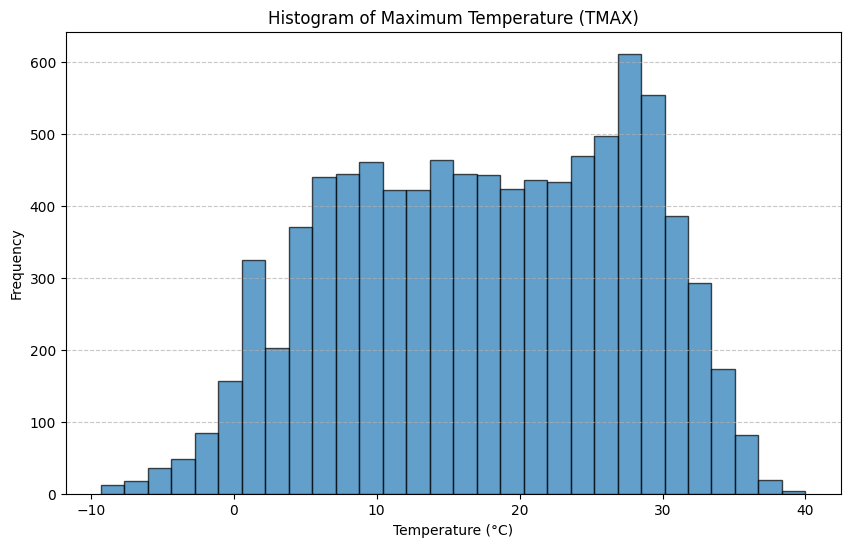

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")

plt.figure(figsize=(10, 6))
plt.hist(df["TMAX"].dropna(), bins=30, edgecolor="black", alpha=0.7)
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.title("Histogram of Maximum Temperature (TMAX)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

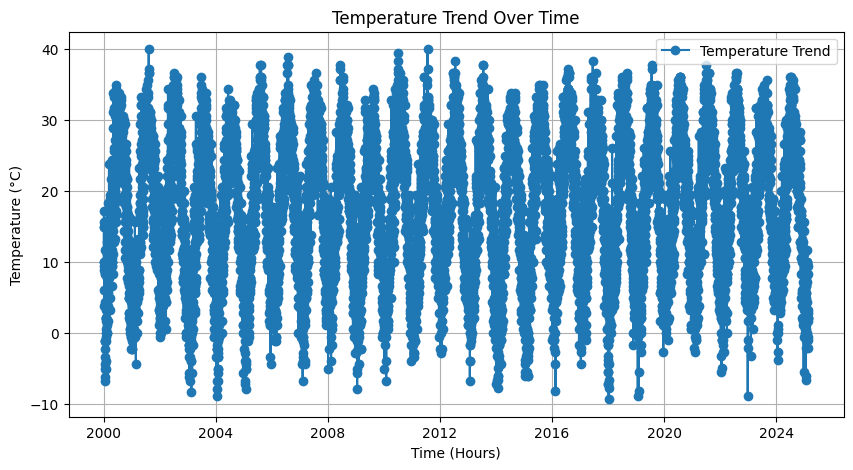

In [ ]:
df['DATE'] = pd.to_datetime(df['DATE'])
df_filtered = df.dropna(subset=['TMAX'])

plt.figure(figsize=(10, 5))
plt.plot(df_filtered['DATE'], df_filtered['TMAX'], marker='o', linestyle='-', label="Temperature Trend")
plt.xlabel("Time (Hours)")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Trend Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [8]:
import os
path = "/content/drive/MyDrive/Cherry Blossom/DATA"
print("Files in directory:", os.listdir(path))

Files in directory: ['kyoto.csv', 'Kyoto_weather.csv', 'liestal.csv', 'liestal_weather.csv', 'washingtondc.csv', 'vancouver.csv', 'nyc.csv', 'nyc_weather.csv', 'vancouver_weather.csv', 'washingtondc_weather.csv']


In [10]:
file_path = '/content/drive/MyDrive/Cherry Blossom/DATA/washingtondc.csv'
df_cherry = pd.read_csv(file_path)
df_cherry.rename(columns={'bloom_date': 'DATE'}, inplace=True)
df_cherry["DATE"] = pd.to_datetime(df_cherry["DATE"], errors="coerce")

In [11]:
df_cherry.columns

Index(['location', 'lat', 'long', 'alt', 'year', 'DATE', 'bloom_doy'], dtype='object')

In [12]:
df_cherry[['location', 'year', 'DATE', 'bloom_doy']]

,location,year,DATE,bloom_doy
0,washingtondc,1921,1921-03-20,79
1,washingtondc,1922,1922-04-07,97
2,washingtondc,1923,1923-04-09,99
3,washingtondc,1924,1924-04-13,104
4,washingtondc,1925,1925-03-27,86
...,...,...,...,...
99,washingtondc,2020,2020-03-20,80
100,washingtondc,2021,2021-03-28,87
101,washingtondc,2022,2022-03-21,80
102,washingtondc,2023,2023-03-23,82
